# Quickstart
This notebook showcases basic examples of how ️buffers implements storing and replaying of experiences.

To maintain the modularity of [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset), we utilize the `EpisodeDataset` to store completed episodes and a `ReplayBuffer` that wraps around the dataset to enable easy adding and sampling of experiences.

## Creating a replay buffer

In [1]:
from buffers import ReplayBuffer
from buffers.dataset import RingBufferDataset

dataset = RingBufferDataset(capacity=10000)
replay_buffer = ReplayBuffer(dataset, batch_size=32, sequence_length=10)

## Storing data from sample environment

In [2]:
import gymnasium as gym
from pprint import pprint
from buffers.utils import to_torch
from tqdm import tqdm

env = gym.make("Pendulum-v1", render_mode="rgb_array")
env.action_space.seed(42)
observation, info = env.reset(seed=42)

for _ in tqdm(range(500), desc="Generating experiences"):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = to_torch(env.step(action))
    
    if terminated or truncated:
        observation, info = to_torch(env.reset())
        
    image = to_torch(env.render())
    
    replay_buffer.add_step({"obs": observation, "image": image, "reward": reward}, done=terminated or truncated)

env.close()

Generating experiences: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 315.12it/s]


## Inspecting the replay buffer
We can inspect the state of the replay buffer through various functionalities.

**1.** A general overview shows how much data is stored and under which keys.

In [3]:
print(replay_buffer.dataset)

RingBufferDataset(
    num_episodes: 2
    num_timesteps: 400
    fields: ['obs', 'image', 'reward'] 
)


**2.** The fields of the dataset describe what type of data is stored under each key.

In [4]:
pprint(replay_buffer.dataset.fields)

{'image': ColorImage(device=device(type='cpu'), height=500, width=500),
 'obs': Vector(device=device(type='cpu'),
               dtype=torch.float32,
               shape=torch.Size([3])),
 'reward': Scalar(device=device(type='cpu'), dtype=torch.float64)}


**3.** Properties can give us detailed information about the state of the dataset.

In [5]:
print(replay_buffer.dataset.is_empty)

False


In [6]:
print(replay_buffer.dataset.episode_lengths)

[200, 200]


## Sampling from the replay buffer
We can iterate through the data as soon as completed episodes have been added.
To do so, we call the replay buffer's `sample` to retrieve a dictionary of tensors of shape `[batch_size, sequence_length, ...]`.
The sampled sequences respect episode boundaries making them suitable for recurrent learning methods.

In [7]:
batch = replay_buffer.sample()
print([{k: v.shape for k, v in batch.items()}])

[{'obs': torch.Size([32, 10, 3]), 'image': torch.Size([32, 10, 500, 500, 3]), 'reward': torch.Size([32, 10])}]


We can visualize the batch to better understand the data.

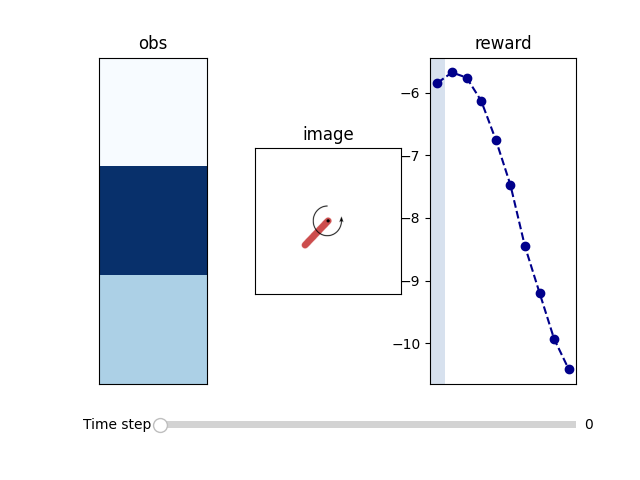

In [8]:
%matplotlib widget
from buffers.visualization import MatplotlibVisualizer

visualizer = MatplotlibVisualizer(replay_buffer.dataset)
visualizer.visualize(batch)